In [1]:
""" 
The algorithm is tested on the PDSystemEnv  gym task 
and developed with Tensorflow

Author: Daniel Salgado Rojo
"""

import tensorflow as tf
import numpy as np
import gym
import gym_pdsystem
from gym import wrappers
#import tflearn
import argparse
import pprint as pp

#from ddpg.replay_buffer import ReplayBuffer

from datetime import datetime

import random

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc


from matplotlib import animation, rc
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import HTML


import pandas as pd
import time

from functools import partial

import os

#TO OMMIT WARNINGS
import warnings
warnings.filterwarnings('ignore')

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)   

/home/dsalgador/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# System's parmeters

In [2]:
# In order to change the parameters of the system, such as number of shops, trucks, etc, one must change
# the corresponding constants in the 'constants.py' file from the 'gym pd_system' package.

CASE = ct.CASE
STOCHASTIC = ct.STOCHASTIC 

###########################################################

TANK_MAX_LOADS = ct.TANK_MAX_LOADS
LEVEL_PERCENTAGES = ct.LEVEL_PERCENTAGES 
TRUCK_MAX_LOADS = ct.TRUCK_MAX_LOADS
GRAPH_WEIGHTS = ct.GRAPH_WEIGHTS 
DISCRETE = ct.DISCRETE

n = len(TANK_MAX_LOADS)
k = len(TRUCK_MAX_LOADS)

env = gym.make("PDSystemEnv-v0")
episode_length = 30
env._max_episode_steps = episode_length

###########################################################

print("System with k={} trucks and n={} shops. Episodes of {} days.".format(k,n,episode_length))

System with k=3 trucks and n=12 shops. Episodes of 30 days.


In [3]:
import utils_pg
from utils_pg import int_to_action
from utils_pg import action_to_int
from utils_pg import discount_rewards
from utils_pg import normalize_rewards

# Tensorflow graph (DNN) for MC Policy Gradient Algorithm

In [4]:
simulation_id = 425

# Create directories for the simulations' outputs

simulation_directory = './simulations/simulation{}'.format(simulation_id)
rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
models_dir = simulation_directory + '/NN-models'

if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
    os.makedirs(models_dir)
    os.makedirs(simulation_directory + '/discrewards')
    os.makedirs(simulation_directory + '/vis')
    
else:
    raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")

# Output headers to file
with open(rewards_file,'w') as f:
     np.savetxt(f, [["iteration", "discreward"]], fmt="%s", delimiter=',')

In [5]:
seed = 42
reset_graph(seed)

################################
# TensorBoard summary directories
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)   
################################

## DNN hyperparameters ################
learning_rate = 0.01 #0.01

hidden1_neurons = 100 #100
hidden2_neurons = 50 #50

# batch_normalization = True  
# batch_norm_momentum = 0.9
######################################



######################################
#### Training hyperparameters ########
######################################
# File names for the model

model_file = models_dir + "/pdenv_policy_net_pg.ckpt"#.format(learning_rate)
best_model_file = models_dir + "/pdenv_best_policy_net_pg.ckpt"#.format(learning_rate)
graph_file =  '{}.meta'.format(model_file)


# Simulation / Training parameters
n_games_per_update = 10
n_max_steps = episode_length
n_iterations = 10**5 #2*10**4
save_iterations = 100 # USEFUL WHEN USING EARLY STOPPING
discount_rate = 0.9

info_freq = 100 #100
round_time = 2
round_reward = 6
summary_freq = 20#int(info_freq/2), 10

# Early stopping
max_checks_without_progress = np.inf # 10,  one for each "info_freq" (in terms of iterations it would be
                                                            #max_checks_without_progress *  info_freq)
checks_without_progress = 0
best_reward = -np.infty


retrain = False
########################################



###### TENSORFLOW GRAPH #########
tf.set_random_seed(seed)
with tf.name_scope("dnn"):
        
            # 1. Parameters to determine the NN architecture

            n_inputs = env.observation_space.shape[1]
            n_hidden1 = hidden1_neurons; activation1 = tf.nn.sigmoid#tf.nn.elu
            n_hidden2 = hidden2_neurons; activation2 = tf.nn.sigmoid#tf.nn.elu
            n_outputs = env.action_space.shape[1]**env.action_space.shape[0]
            
            he_init = tf.contrib.layers.variance_scaling_initializer(seed = seed)

            X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
            
                    
            hidden1 = tf.layers.dense(X, n_hidden1, activation = activation1,
                                     kernel_initializer = he_init)
            hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = activation2,
                                     kernel_initializer = he_init)
            logits = tf.layers.dense(hidden2, n_outputs, name = "logits"
                                     ,kernel_initializer = he_init)
            
            outputs = tf.nn.softmax(logits)
                   
            
with tf.name_scope("action"):
            # 3. Select a random action (where to go) based on the estimated probabilities
            action = tf.multinomial(tf.log(outputs), num_samples = 1)
            test_action = tf.argmax(outputs, axis = 1)
  
            y = tf.reshape(action, [1])
            
with tf.name_scope("loss"):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,logits = logits)
            loss = tf.reduce_mean(xentropy, name = "loss")
            
tf.summary.scalar('average_cross_entropy', loss)


with tf.name_scope("train"):
            # Optimization Op
            optimizer = tf.train.AdamOptimizer(learning_rate)
            
            grads_and_vars = optimizer.compute_gradients(xentropy)
            gradients = [grad for grad, variable in grads_and_vars]
            gradient_placeholders = []
            grads_and_vars_feed = []
            for grad, variable in grads_and_vars:
                gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
                gradient_placeholders.append(gradient_placeholder)
                grads_and_vars_feed.append((gradient_placeholder, variable))
            training_op = optimizer.apply_gradients(grads_and_vars_feed)
                        
                                       
merged = tf.summary.merge_all()
init = tf.global_variables_initializer()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
        
saver = tf.train.Saver()
        

Instructions for updating:
Use the retry module or similar alternatives.


# PG Training

In [6]:
with tf.Session() as sess:
    
    #train_writer = tf.summary.FileWriter(logdir + '/pgtrain', sess.graph)
    if retrain:
        saver.restore(sess, model_file)
        
    summary2 = tf.Summary()
    if not retrain:
        init.run()
    time_start = time.time()

    for iteration in range(n_iterations+1):
        print("\rIteration: {}".format(iteration), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)}) 
                #print(action_val)
                vect_action = int_to_action(action_val,env) #HERE WE CONVERT FROM INTEGER TO ACTION's Array
                #print(vect_action)
                obs, reward, done, info = env.step(vect_action)
                current_rewards.append(reward)
                current_gradients.append(gradients_val)                
                
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
            
        
        all_disc_rewards =  [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
        all_disc_norm_rewards = normalize_rewards(all_disc_rewards)     

        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_disc_norm_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
         
       
        #tf.summary.scalar('avg_rewards', avg_rewards)
        #train_writer.add_summary(avg_rewards, iteration)

        # Summary and info printings     ###################################################################
        if iteration % info_freq == 0 or iteration % summary_freq == 0:  
            
            #avg_rewards =np.array([np.mean(np.array(all_rewards)) / n_games_per_update])
            avg_rewards =np.mean(np.array(all_disc_rewards)) / n_games_per_update
#             print(avg_rewards)
            #avg_rewards_list.append(avg_rewards)
            if iteration % summary_freq == 0:
                summary2.value.add(tag='average_reward_per_game', simple_value = avg_rewards)
                file_writer.add_summary(summary2, iteration)

                feed_dict[X] = obs.reshape(1, n_inputs)
                summary = sess.run(merged, feed_dict= feed_dict)

                file_writer.add_summary(summary, iteration)
                
                  # Disc rewards, etc ####
       
                with open(rewards_file,'ab') as f:
                            np.savetxt(f, [np.array([iteration,  avg_rewards])], fmt=("%d",'%.10f'), delimiter=',') 

            if iteration % info_freq == 0:
                time_end = time.time()
                print(". Average reward per game: ",  round(avg_rewards, round_reward), 
                      ", Elapsed time ", round( (time_end-time_start)/60., round_time), " minutes.") 
                
                
        ###########################################################################      
                
        if avg_rewards > best_reward:
                    saver.save(sess, best_model_file)
                    print("Saved Model with average discounted rewards per game ", avg_rewards)
                    best_reward = avg_rewards
                    checks_without_progress = 0
        else:
                    checks_without_progress += 1
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
        ####################################################################################################
        if iteration % save_iterations == 0:
                 saver.save(sess, model_file)
        
        sess.run(training_op, feed_dict=feed_dict)
    
    #saver.save(sess, model_file + "final")
    file_writer.flush()
    file_writer.close()
                 
    time_end = time.time()
    print("Simulation finished. Elapsed time ", round( (time_end-time_start)/60., round_time), " minutes.") 
        

Iteration: 0. Average reward per game:  -4.201114 , Elapsed time  0.02  minutes.
Saved Model with average discounted rewards per game  -4.201114270589446
Iteration: 20Saved Model with average discounted rewards per game  -3.3116030692861225
Iteration: 40Saved Model with average discounted rewards per game  -2.6725794629522417
Iteration: 60Saved Model with average discounted rewards per game  -2.4779112774334324
Iteration: 80Saved Model with average discounted rewards per game  -2.2551770137596274
Iteration: 100. Average reward per game:  -2.026858 , Elapsed time  1.75  minutes.
Saved Model with average discounted rewards per game  -2.026857890310954
Iteration: 120Saved Model with average discounted rewards per game  -1.9743185914423727
Iteration: 160Saved Model with average discounted rewards per game  -1.6604582448093865
Iteration: 200. Average reward per game:  -1.685616 , Elapsed time  3.25  minutes.
Iteration: 240Saved Model with average discounted rewards per game  -1.423043470513

Iteration: 7600. Average reward per game:  -1.087527 , Elapsed time  117.34  minutes.
Iteration: 7620Saved Model with average discounted rewards per game  -0.9911304862865464
Iteration: 7640Saved Model with average discounted rewards per game  -0.9901467138631755
Iteration: 7700. Average reward per game:  -1.101329 , Elapsed time  118.97  minutes.
Iteration: 7800. Average reward per game:  -1.30209 , Elapsed time  120.63  minutes.
Iteration: 7900. Average reward per game:  -1.234549 , Elapsed time  121.92  minutes.
Iteration: 8000. Average reward per game:  -1.141676 , Elapsed time  123.72  minutes.
Iteration: 8100. Average reward per game:  -1.18223 , Elapsed time  125.62  minutes.
Iteration: 8200. Average reward per game:  -1.410769 , Elapsed time  127.43  minutes.
Iteration: 8300. Average reward per game:  -1.160025 , Elapsed time  129.03  minutes.
Iteration: 8400. Average reward per game:  -1.093158 , Elapsed time  130.5  minutes.
Iteration: 8500. Average reward per game:  -1.13612

Iteration: 16600. Average reward per game:  -1.358174 , Elapsed time  256.2  minutes.
Iteration: 16700. Average reward per game:  -1.230782 , Elapsed time  257.66  minutes.
Iteration: 16800. Average reward per game:  -1.262357 , Elapsed time  259.13  minutes.
Iteration: 16900. Average reward per game:  -1.344279 , Elapsed time  260.53  minutes.
Iteration: 17000. Average reward per game:  -1.403823 , Elapsed time  340.09  minutes.
Iteration: 17100. Average reward per game:  -1.36674 , Elapsed time  341.2  minutes.
Iteration: 17200. Average reward per game:  -1.162759 , Elapsed time  342.56  minutes.
Iteration: 17300. Average reward per game:  -1.001098 , Elapsed time  343.91  minutes.
Iteration: 17400. Average reward per game:  -1.180236 , Elapsed time  345.26  minutes.
Iteration: 17500. Average reward per game:  -1.114848 , Elapsed time  346.64  minutes.
Iteration: 17600. Average reward per game:  -1.199609 , Elapsed time  348.01  minutes.
Iteration: 17700. Average reward per game:  -0

Iteration: 26000. Average reward per game:  -1.271821 , Elapsed time  492.12  minutes.
Iteration: 26100. Average reward per game:  -1.521423 , Elapsed time  494.0  minutes.
Iteration: 26200. Average reward per game:  -1.071659 , Elapsed time  495.54  minutes.
Iteration: 26300. Average reward per game:  -1.167052 , Elapsed time  497.4  minutes.
Iteration: 26400. Average reward per game:  -1.196088 , Elapsed time  499.11  minutes.
Iteration: 26500. Average reward per game:  -1.055652 , Elapsed time  500.99  minutes.
Iteration: 26600. Average reward per game:  -1.031018 , Elapsed time  502.73  minutes.
Iteration: 26700. Average reward per game:  -1.087368 , Elapsed time  504.48  minutes.
Iteration: 26800. Average reward per game:  -1.163948 , Elapsed time  506.23  minutes.
Iteration: 26900. Average reward per game:  -1.138472 , Elapsed time  507.86  minutes.
Iteration: 27000. Average reward per game:  -1.2628 , Elapsed time  509.53  minutes.
Iteration: 27100. Average reward per game:  -0.

Iteration: 35200. Average reward per game:  -1.114029 , Elapsed time  651.21  minutes.
Iteration: 35300. Average reward per game:  -1.122871 , Elapsed time  653.15  minutes.
Iteration: 35400. Average reward per game:  -1.16009 , Elapsed time  655.1  minutes.
Iteration: 35500. Average reward per game:  -0.955418 , Elapsed time  656.99  minutes.
Iteration: 35600. Average reward per game:  -0.999805 , Elapsed time  658.9  minutes.
Iteration: 35700. Average reward per game:  -1.005619 , Elapsed time  660.85  minutes.
Iteration: 35740Saved Model with average discounted rewards per game  -0.8289085628953495
Iteration: 35800. Average reward per game:  -0.991534 , Elapsed time  662.8  minutes.
Iteration: 35900. Average reward per game:  -1.076044 , Elapsed time  664.8  minutes.
Iteration: 36000. Average reward per game:  -1.262477 , Elapsed time  666.72  minutes.
Iteration: 36100. Average reward per game:  -0.965323 , Elapsed time  668.61  minutes.
Iteration: 36200. Average reward per game:  -

Iteration: 44400. Average reward per game:  -1.075206 , Elapsed time  789.0  minutes.
Iteration: 44500. Average reward per game:  -1.055697 , Elapsed time  789.92  minutes.
Iteration: 44600. Average reward per game:  -1.158454 , Elapsed time  790.84  minutes.
Iteration: 44700. Average reward per game:  -0.970129 , Elapsed time  791.76  minutes.
Iteration: 44800. Average reward per game:  -0.965169 , Elapsed time  792.69  minutes.
Iteration: 44900. Average reward per game:  -1.020199 , Elapsed time  793.63  minutes.
Iteration: 45000. Average reward per game:  -0.963849 , Elapsed time  794.54  minutes.
Iteration: 45100. Average reward per game:  -1.015298 , Elapsed time  795.46  minutes.
Iteration: 45200. Average reward per game:  -0.959593 , Elapsed time  796.37  minutes.
Iteration: 45300. Average reward per game:  -0.959763 , Elapsed time  797.29  minutes.
Iteration: 45400. Average reward per game:  -1.06 , Elapsed time  798.22  minutes.
Iteration: 45500. Average reward per game:  -1.0

Iteration: 53700. Average reward per game:  -1.021265 , Elapsed time  875.21  minutes.
Iteration: 53800. Average reward per game:  -1.02363 , Elapsed time  876.14  minutes.
Iteration: 53900. Average reward per game:  -0.896228 , Elapsed time  877.08  minutes.
Iteration: 54000. Average reward per game:  -1.006575 , Elapsed time  878.04  minutes.
Iteration: 54100. Average reward per game:  -1.027113 , Elapsed time  878.98  minutes.
Iteration: 54200. Average reward per game:  -0.932135 , Elapsed time  879.91  minutes.
Iteration: 54300. Average reward per game:  -0.792698 , Elapsed time  880.85  minutes.
Iteration: 54400. Average reward per game:  -0.952996 , Elapsed time  881.78  minutes.
Iteration: 54500. Average reward per game:  -0.954229 , Elapsed time  882.72  minutes.
Iteration: 54600. Average reward per game:  -0.906182 , Elapsed time  883.65  minutes.
Iteration: 54700. Average reward per game:  -0.878694 , Elapsed time  884.58  minutes.
Iteration: 54800. Average reward per game:  

Iteration: 63200. Average reward per game:  -1.008207 , Elapsed time  963.87  minutes.
Iteration: 63300. Average reward per game:  -0.955663 , Elapsed time  964.8  minutes.
Iteration: 63400. Average reward per game:  -1.053468 , Elapsed time  965.73  minutes.
Iteration: 63500. Average reward per game:  -1.132687 , Elapsed time  966.67  minutes.
Iteration: 63600. Average reward per game:  -1.035407 , Elapsed time  967.6  minutes.
Iteration: 63700. Average reward per game:  -1.06125 , Elapsed time  968.53  minutes.
Iteration: 63800. Average reward per game:  -0.976746 , Elapsed time  969.47  minutes.
Iteration: 63900. Average reward per game:  -0.87554 , Elapsed time  970.41  minutes.
Iteration: 64000. Average reward per game:  -0.969373 , Elapsed time  971.35  minutes.
Iteration: 64100. Average reward per game:  -1.106737 , Elapsed time  972.3  minutes.
Iteration: 64200. Average reward per game:  -1.029336 , Elapsed time  973.25  minutes.
Iteration: 64300. Average reward per game:  -1.0

Iteration: 72600. Average reward per game:  -0.908215 , Elapsed time  1051.99  minutes.
Iteration: 72700. Average reward per game:  -0.896221 , Elapsed time  1052.92  minutes.
Iteration: 72800. Average reward per game:  -0.979016 , Elapsed time  1053.84  minutes.
Iteration: 72900. Average reward per game:  -0.920377 , Elapsed time  1054.79  minutes.
Iteration: 73000. Average reward per game:  -0.94374 , Elapsed time  1055.74  minutes.
Iteration: 73100. Average reward per game:  -1.220563 , Elapsed time  1056.67  minutes.
Iteration: 73200. Average reward per game:  -0.897665 , Elapsed time  1057.62  minutes.
Iteration: 73300. Average reward per game:  -0.998359 , Elapsed time  1058.56  minutes.
Iteration: 73400. Average reward per game:  -1.028775 , Elapsed time  1059.49  minutes.
Iteration: 73500. Average reward per game:  -1.013106 , Elapsed time  1060.43  minutes.
Iteration: 73600. Average reward per game:  -1.025227 , Elapsed time  1061.37  minutes.
Iteration: 73700. Average reward 

Iteration: 82000. Average reward per game:  -1.286805 , Elapsed time  1140.4  minutes.
Iteration: 82100. Average reward per game:  -1.173655 , Elapsed time  1141.37  minutes.
Iteration: 82200. Average reward per game:  -1.239751 , Elapsed time  1142.32  minutes.
Iteration: 82300. Average reward per game:  -1.056627 , Elapsed time  1143.3  minutes.
Iteration: 82400. Average reward per game:  -1.361929 , Elapsed time  1144.23  minutes.
Iteration: 82500. Average reward per game:  -1.151308 , Elapsed time  1145.19  minutes.
Iteration: 82600. Average reward per game:  -0.964858 , Elapsed time  1146.14  minutes.
Iteration: 82700. Average reward per game:  -1.147674 , Elapsed time  1147.13  minutes.
Iteration: 82800. Average reward per game:  -1.114298 , Elapsed time  1148.08  minutes.
Iteration: 82900. Average reward per game:  -1.226948 , Elapsed time  1149.03  minutes.
Iteration: 83000. Average reward per game:  -0.93616 , Elapsed time  1149.98  minutes.
Iteration: 83100. Average reward pe

Iteration: 91400. Average reward per game:  -1.374592 , Elapsed time  1280.9  minutes.
Iteration: 91500. Average reward per game:  -1.254977 , Elapsed time  1281.91  minutes.
Iteration: 91600. Average reward per game:  -1.179806 , Elapsed time  1282.91  minutes.
Iteration: 91700. Average reward per game:  -1.407343 , Elapsed time  1283.92  minutes.
Iteration: 91800. Average reward per game:  -1.143788 , Elapsed time  1284.92  minutes.
Iteration: 91900. Average reward per game:  -1.280362 , Elapsed time  1285.96  minutes.
Iteration: 92000. Average reward per game:  -1.220194 , Elapsed time  1286.98  minutes.
Iteration: 92100. Average reward per game:  -1.192448 , Elapsed time  1288.02  minutes.
Iteration: 92200. Average reward per game:  -1.305682 , Elapsed time  1289.03  minutes.
Iteration: 92300. Average reward per game:  -1.279311 , Elapsed time  1290.06  minutes.
Iteration: 92400. Average reward per game:  -1.261388 , Elapsed time  1291.07  minutes.
Iteration: 92500. Average reward 

## Visualizations

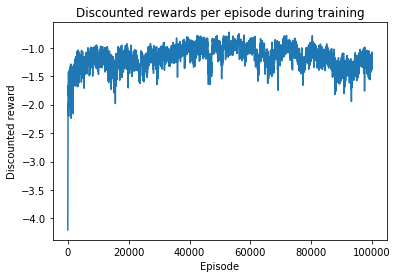

In [7]:
# Visualizing train simulation:

#episode =episodes
#simulation_id = 2
#step = 30

discrewards = pd.read_table(rewards_file, sep = ",")

indices = [i for i in range(0,n_iterations,1)]

plt.plot(discrewards['iteration'][indices],discrewards['discreward'][indices], label = "Discounted rewards")
plt.title("Discounted rewards per episode during training")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")

plt.savefig(simulation_directory + '/discounted-rewards-sim' + '{}'.format(simulation_id) + '.pdf')

plt.show()
plt.close()

# PG Testing

In [8]:
seed = 45 # this seed determines the initialization of the system when calling env.reset() ,etc
np.random.seed(seed)

frames = []
n_episodes = 1

system = PDSystemEnv()
#model_file = "pdenv_policy_net_pg.ckpt"
test_model_file = best_model_file

with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4",
                        "stock5","stock6","stock7","stock8","stock9","stock10","stock11"]], fmt="%s", delimiter=',') 


with tf.Session() as sess:
        sess.run(init)
        saver.restore(sess, test_model_file)
        for episode in range(n_episodes):
            state = env.reset()
            for step in range(episode_length):
                system.state = state
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode)*(episode_length)+step]+state.tolist())], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f','%.3f','%.3f','%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',') 
                img = system.visualize()
                frames.append(img)

                action_val = test_action.eval(feed_dict={X: state.reshape(1, n_inputs)})
                #print(action_val)
                vect_action = int_to_action(action_val,env) #HERE WE CONVERT FROM INTEGER TO ACTION's Array
                #print(vect_action)
                state, reward, done, info = env.step(vect_action)
               
        env.close()
    

INFO:tensorflow:Restoring parameters from ./simulations/simulation425/NN-models/pdenv_best_policy_net_pg.ckpt


## Giff animation

In [9]:
test_anim = ut.create_system_animation(frames, n_episodes * episode_length)
plt.close()

HTML(test_anim.to_html5_video())

## Visualization with matplotlib

In [10]:
from utils_pg import is_empty
from utils_pg import my_indicator

def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory,
                        level_counts_list):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    #tanks = test_toy_system.tanks
    tanks_max_load = system.tank_max_loads
    level_percentages = system.load_level_percentages

    for i, color in enumerate(colors, start=1):    
        plt.subplot(4,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, level_percentages[i-1]):
            plt.axhline(y= lvl * tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = level_percentages[i-1]           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length*n_episodes+1,5*n_episodes
                        ))
        
        #################### INFO LEVELS
        b = percentages[0]
        level_counts = np.zeros(5, dtype = np.int64)
        
        x_mins = np.array([0,b,c,e])*tanks_max_load[i-1]
        x_maxs = np.array([b,c,e,1])*tanks_max_load[i-1]

        for x in states:
            level_counts[0] = level_counts[0] + is_empty(x)
            for j in range(1,5):
                level_counts[j] = level_counts[j] + my_indicator(x_mins[j-1], x, x_maxs[j-1])
            
        level_counts_list.append(level_counts)
        ###################################################

#     plt.subplot(4,3,6)
#     plt.title("Legend")
#     plt.axis('off')

#     #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
#     plt.yticks([])
#     plt.xticks([])

#     patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
#     patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
#     patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
#     patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
#     patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
#     patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


#     plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + '{}'.format(simulation_id) + '.pdf')
    plt.show()
    plt.close()

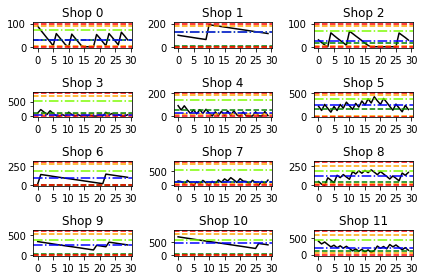

In [11]:
test_level_counts_list = []

visualize_simulation(states_file,
                        system,
                        simulation_id,
                        simulation_directory,
                        level_counts_list = test_level_counts_list)   

## Performance metrics

INFO:tensorflow:Restoring parameters from ./simulations/simulation425/NN-models/pdenv_best_policy_net_pg.ckpt


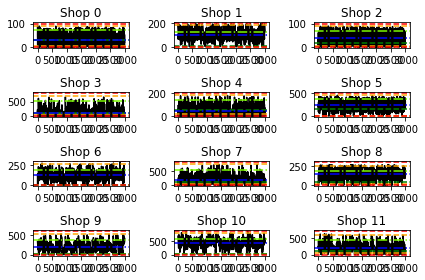

Total discounted rewards Level rewards Transport rewards
-9.700768553681664 -31.95994120792869 0.07935168889470001
Average trucks sent:  77.53
Average 1st type Trucks sent to each shop: [ 6.44  0.    4.38  0.   12.47  0.    0.    1.29  5.42  0.    0.    0.
  0.  ]
Average 1st type Trucks sent: 30.0
Average 2nd type Trucks sent to each shop: [ 0.    1.7   0.    8.1   0.    0.    1.29  0.    4.78  1.66  0.   12.47
  0.  ]
Average 2nd type Trucks sent: 30.0
Average number of trucks not deliverying: 3.64
Average level counts for shop 0: [ 6.51  0.48  9.41 13.6   0.  ]
Average level counts for shop 1: [ 0.64  0.04  0.15 28.25  0.92]
Average level counts for shop 2: [ 2.82  0.71  3.29 23.18  0.  ]
Average level counts for shop 3: [9.94 8.32 2.95 8.79 0.  ]
Average level counts for shop 4: [ 3.79  5.95 10.73  9.53  0.  ]
Average level counts for shop 5: [ 0.14  0.05  5.66 24.15  0.  ]
Average level counts for shop 6: [ 0.44  0.07  0.22 29.21  0.06]
Average level counts for shop 7: [ 0.89  1.4

In [15]:
seed = 45 # this seed determines the initialization of the system when calling env.reset() ,etc
np.random.seed(seed)

frames = []
n_episodes = 100

system = PDSystemEnv()
#model_file = "pdenv_policy_net_pg.ckpt"
test_model_file = best_model_file

with open(states_file,'w') as f:
    np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4",
                        "stock5","stock6","stock7","stock8","stock9","stock10","stock11"]], fmt="%s", delimiter=',') 
####
test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []
test_number_of_first_trucks_sent_list = []
test_number_of_second_trucks_sent_list = []
test_number_of_trucks_not_deliverying_list = []
####

with tf.Session() as sess:
        sess.run(init)
        saver.restore(sess, test_model_file)
        for episode in range(n_episodes):
            #####
            discounted_reward = 0 
            transport_rewards = 0
            level_rewards = 0
            number_of_trucks_sent = 0
            number_of_first_trucks_sent = np.zeros(n+1, dtype = np.int64)
            number_of_second_trucks_sent = np.zeros(n+1, dtype = np.int64)
            number_of_trucks_not_deliverying = 0                   
            #####         
         
            state = env.reset()
            for step in range(episode_length):
                system.state = state
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode)*(episode_length)+step]+state.tolist())], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f','%.3f','%.3f','%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',') 
                img = system.visualize()
                frames.append(img)

                action_val = test_action.eval(feed_dict={X: state.reshape(1, n_inputs)})
                #print(action_val)
                vect_action = int_to_action(action_val,env) #HERE WE CONVERT FROM INTEGER TO ACTION's Array
                #print(vect_action)
                state, reward, done, info = env.step(vect_action)
            
                trucks_not_del = info["trucks_not_deliverying"]
                level_reward = info["level_rewards"]
                transport_reward = info["transport_rewards"]
                ### STORE STEP INFO
                discounted_reward = discounted_reward + (discount_rate**(step)) * reward
                transport_rewards = transport_rewards+transport_reward
                level_rewards = level_rewards + level_reward
                
                number_of_trucks_sent = number_of_trucks_sent + np.sum(vect_action == 5)
                index1 = vect_action[0]
                number_of_first_trucks_sent[index1] = number_of_first_trucks_sent[index1] + 1
                index2 = vect_action[1]
                number_of_second_trucks_sent[index2] = number_of_second_trucks_sent[index2] + 1
                number_of_trucks_not_deliverying =  number_of_trucks_not_deliverying + trucks_not_del
                
            test_rewards_list.append(discounted_reward);
            test_transport_rewards_list.append(transport_rewards);
            test_level_rewards_list.append(level_rewards);
            test_trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);
            test_number_of_first_trucks_sent_list.append(number_of_first_trucks_sent);
            test_number_of_second_trucks_sent_list.append(number_of_second_trucks_sent);
            test_number_of_trucks_not_deliverying_list.append(number_of_trucks_not_deliverying);                   
                
               
        env.close()
        
test_level_counts_list = []

visualize_simulation(states_file,
                        system,
                        simulation_id,
                        simulation_directory,
                        level_counts_list = test_level_counts_list) 

print("Total discounted rewards","Level rewards", "Transport rewards")
print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)
    
#     if n_episodes == 1:
first_type = sum(test_number_of_first_trucks_sent_list)/n_episodes
print("Average 1st type Trucks sent to each shop:", first_type)
print("Average 1st type Trucks sent:", sum(first_type[0:n] ) )

second_type = sum(test_number_of_second_trucks_sent_list)/n_episodes
print("Average 2nd type Trucks sent to each shop:", second_type)
print("Average 2nd type Trucks sent:",  sum(second_type[0:n] ))

print("Average number of trucks not deliverying:", sum(test_number_of_trucks_not_deliverying_list)/n_episodes )

for i in range(n):
        print("Average level counts for shop {}:".format(i), test_level_counts_list[i]/n_episodes )

        
print("Average total level counts:", sum(test_level_counts_list)/n_episodes )
print("Percentage total level counts:", (sum(test_level_counts_list)/n_episodes)/(episode_length * n) * 100 )